In [ ]:
import torch
import torchvision
from torchvision.io import read_image
from torchvision.models import densenet161, DenseNet161_Weights
from torch.profiler import profile, record_function, ProfilerActivity

from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
images = []
for i in range(1,51):
  images.append(read_image(f"drive/MyDrive/dataset/img{i}.jpg").cuda())

text = ['acoustic guitar', 'microphone', 'moped', 'sports car', 'tennis ball', 'accordion', 'gondola', 'perfume', 'Polaroid camera', 'racket',
        'radio', 'quill', 'refrigerator', 'school bus', 'pillow', 'panpipe', 'oscilloscope', 'muzzle', 'maraca', 'kimono',
        'beacon', 'tiger shark', 'bakery', 'coho', 'barracouta', 'titi', 'bison', 'ice cream', 'trifle', 'pizza',
        'daisy', 'bolete', 'agaric', 'rapeseed', 'corn', 'dough', 'lemon', 'cucumber', 'broccoli','yawl',
        'tray', 'tractor', 'television', 'sax', 'pirate', 'pajama', 'obelisk', 'lifeboat', 'hook', 'goblet']

In [ ]:
from torch.profiler import profile, record_function, ProfilerActivity
import time

N_top_predition = 5 #количество лучших предсказаний, которое мы будем выводить 


description = []
test = []

# Step 1: Инициализация модели
weights = DenseNet161_Weights.IMAGENET1K_V1
model = densenet161(weights=weights).cuda()
model.eval()
top1_accuracy = 0 
top5_accuracy = 0 


# Step 2: Инициализируем препроцессинг
preprocess = weights.transforms()

for i in range(len(images)):
  
  # Step 3: Используем препроцессинг для изображения
  batch = preprocess(images[i]).unsqueeze(0)

  # Step 4: Предсказывем класс предета изображения с помощью модели
  start = time.time()
  with profile(activities=[ProfilerActivity.CPU, ProfilerActivity.CUDA], record_shapes=True, profile_memory=True) as prof:
    with record_function("model_inference"):
      prediction = model(batch).squeeze(0).softmax(0)
  end = time.time()
  test.append(end-start)
  
  top_prediction = torch.topk(prediction.flatten(), N_top_predition).indices

  top_prediction_id = [e.item() for e in top_prediction]

  all_score = [prediction[e].item() for e in top_prediction_id]

  category_names = [weights.meta["categories"][e] for e in top_prediction_id]

  array_description = [f"{top_prediction_id[e]} {category_names[e]}: {100 * all_score[e]:.1f}%" for e in range(N_top_predition)]
  description.append("\n".join(array_description))

  top1_accuracy += 1 if weights.meta["categories"][top_prediction_id[0]] == text[i] else 0
  top5_accuracy += 1 if text[i] in [weights.meta["categories"][e] for e in top_prediction_id] else 0
  

In [ ]:
print(prof.key_averages().table(sort_by="cuda_memory_usage", row_limit=None))

-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                   Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg     Self CUDA   Self CUDA %    CUDA total  CUDA time avg       CPU Mem  Self CPU Mem      CUDA Mem  Self CUDA Mem    # of Calls  
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                            aten::empty         7.59%       3.979ms         7.59%       3.979ms       4.937us       0.000us         0.00%       0.000us       0.000us         268 b         268 b     351.92 Mb     351.92 M

In [ ]:
top1_accuracy = top1_accuracy/len(images)
top5_accuracy = top5_accuracy/len(images)
print(f"top-1 accuracy: {100 * top1_accuracy:.1f}%")
print(f"top-5 accuracy: {100 * top5_accuracy:.1f}%")

top-1 accuracy: 86.0%
top-5 accuracy: 94.0%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  del sys.path[0]


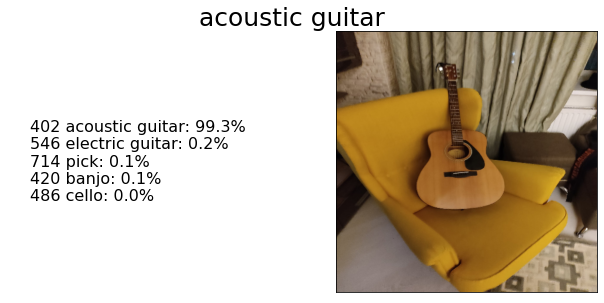

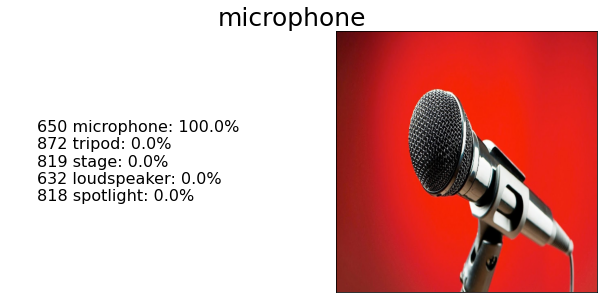

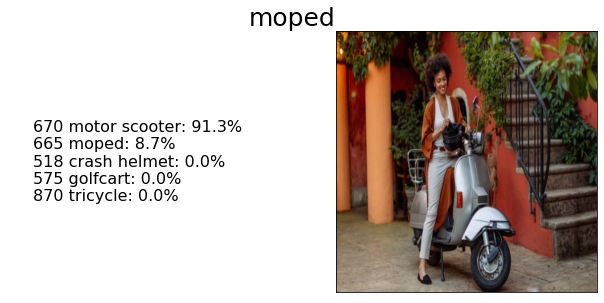

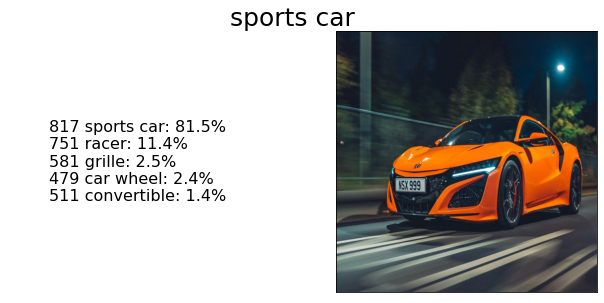

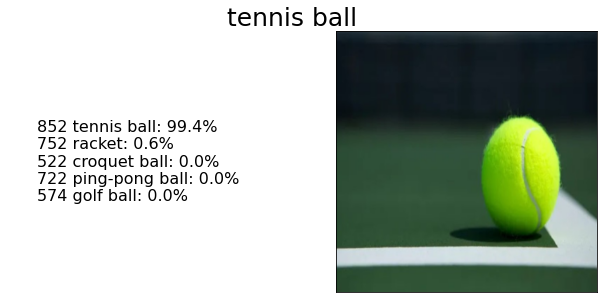

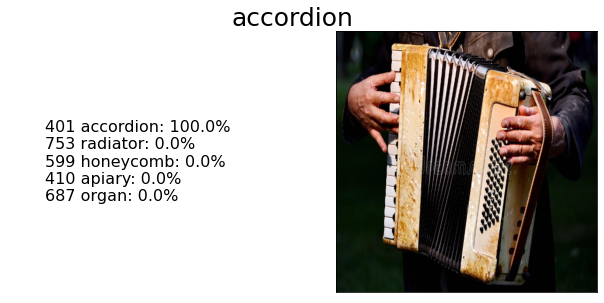

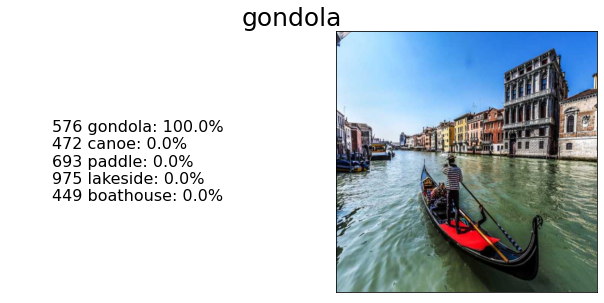

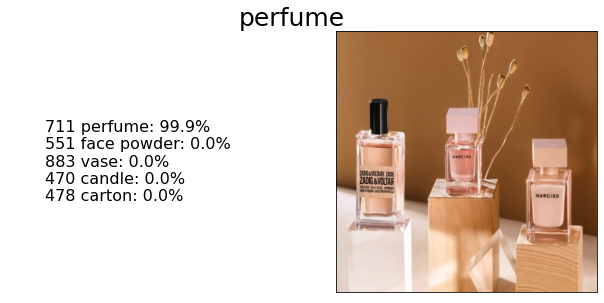

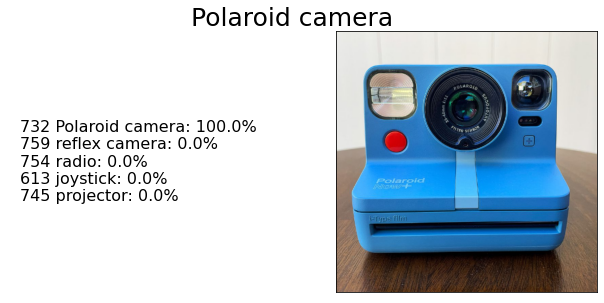

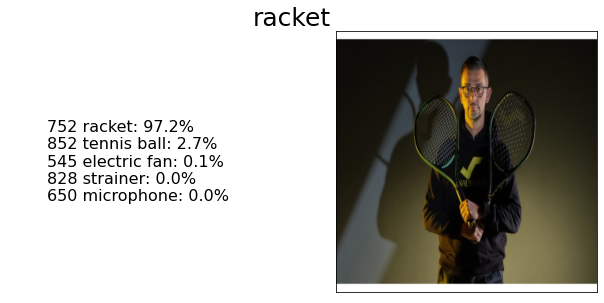

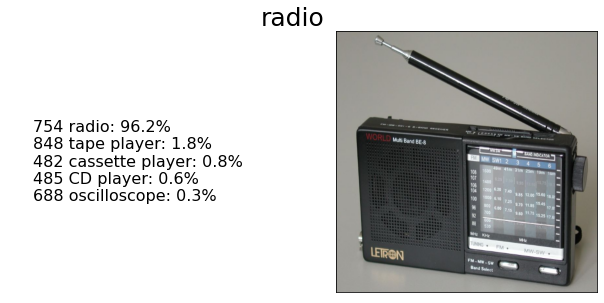

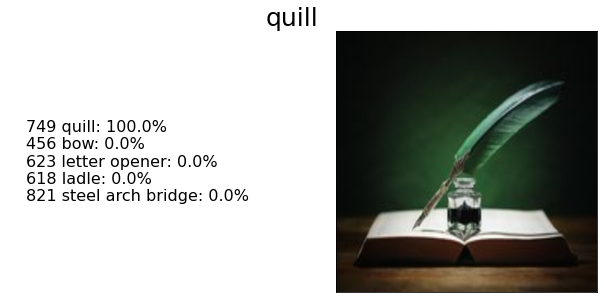

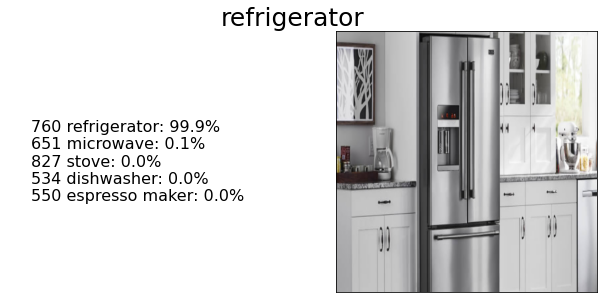

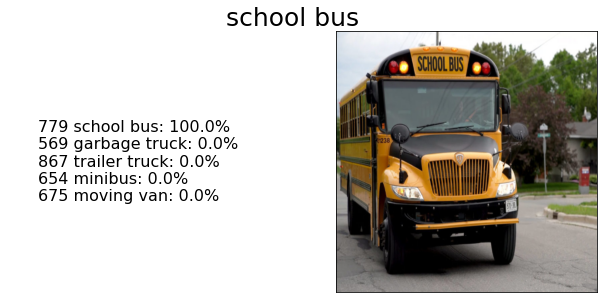

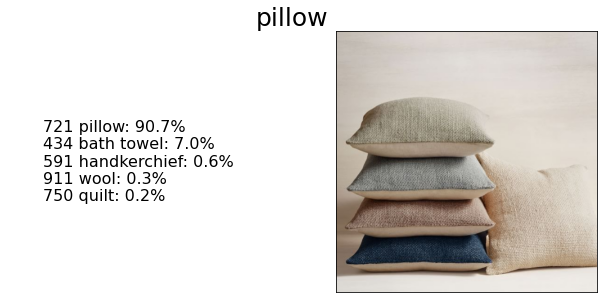

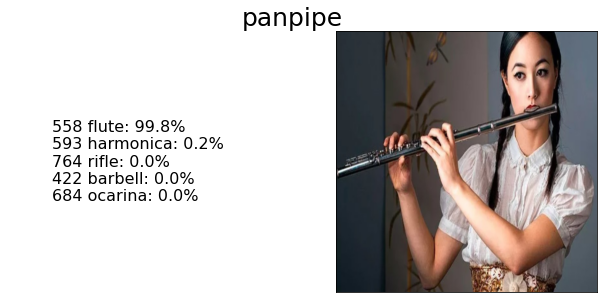

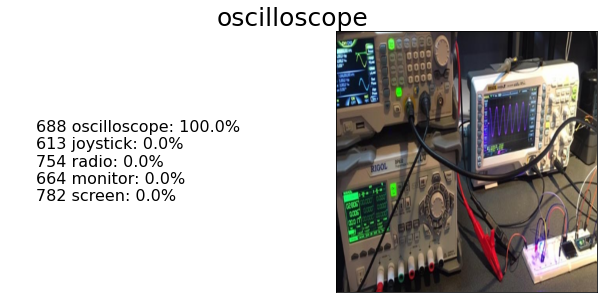

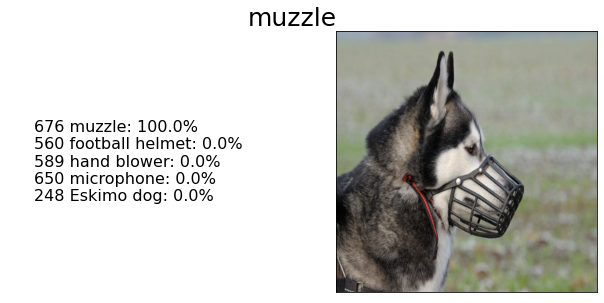

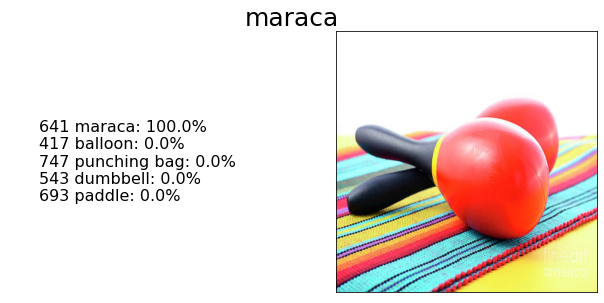

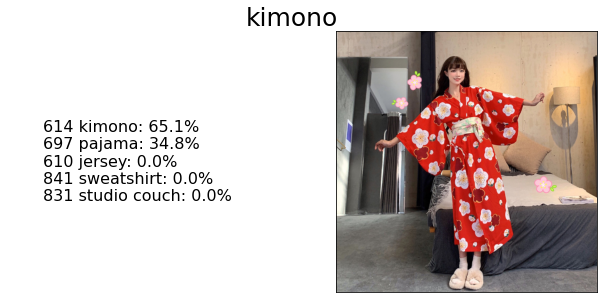

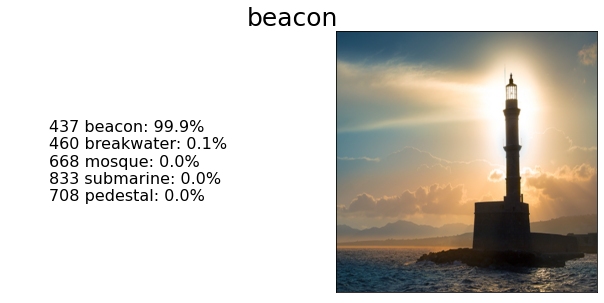

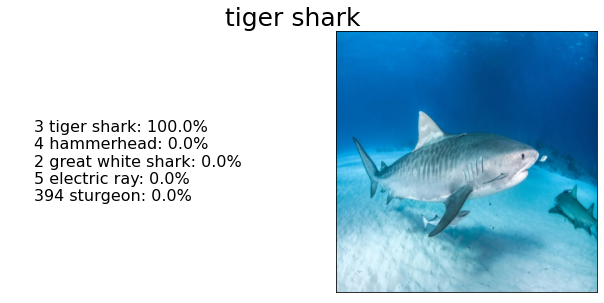

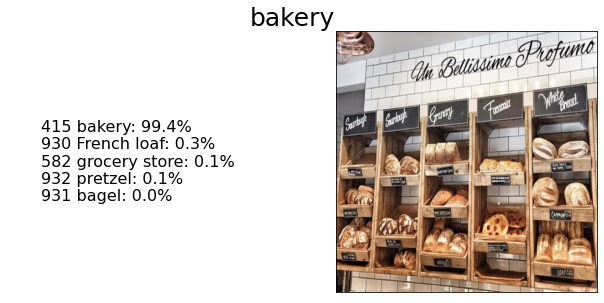

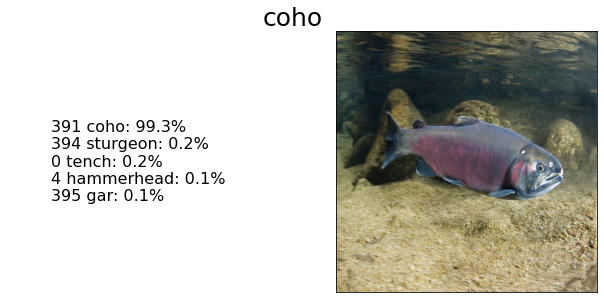

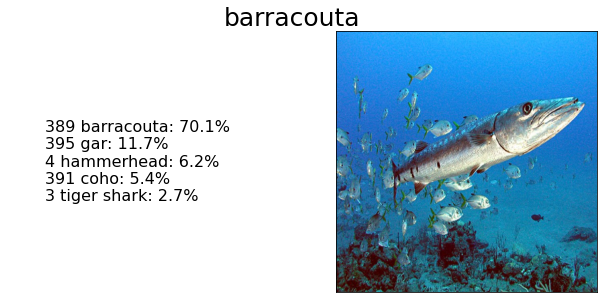

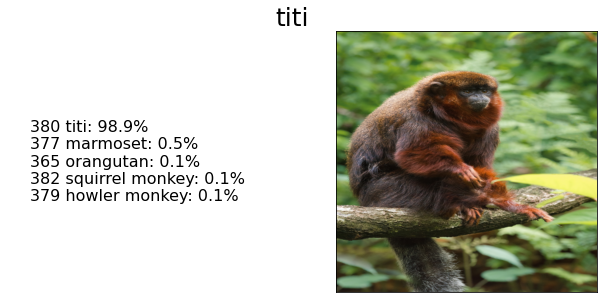

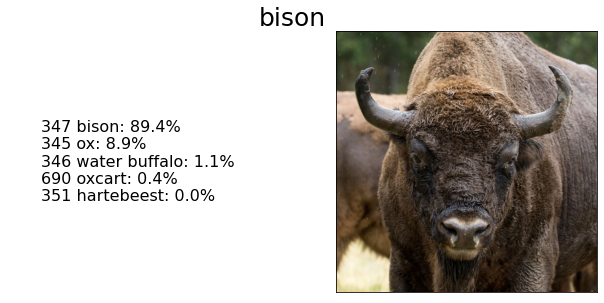

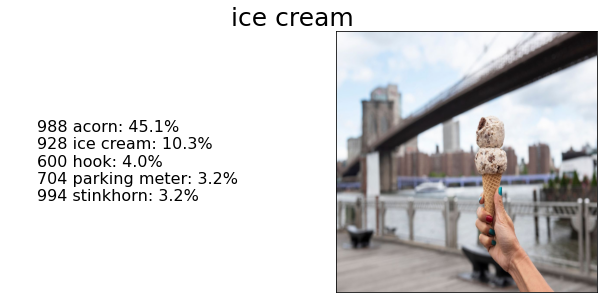

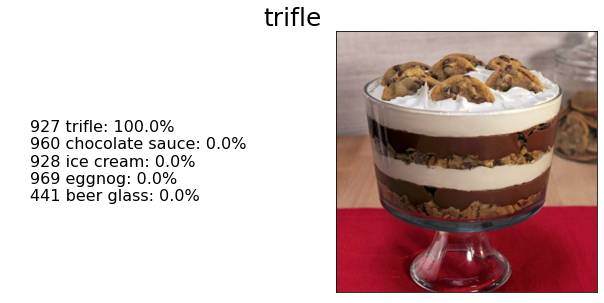

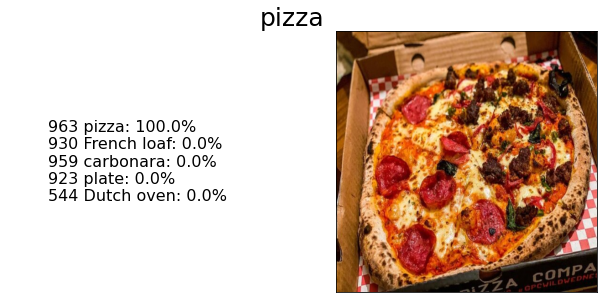

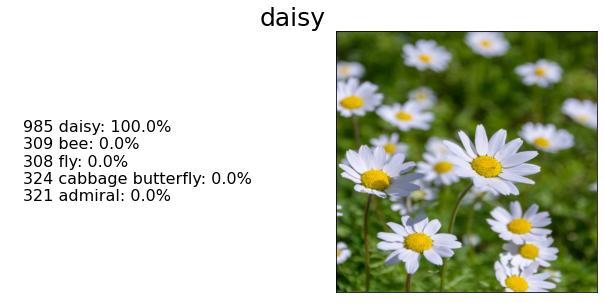

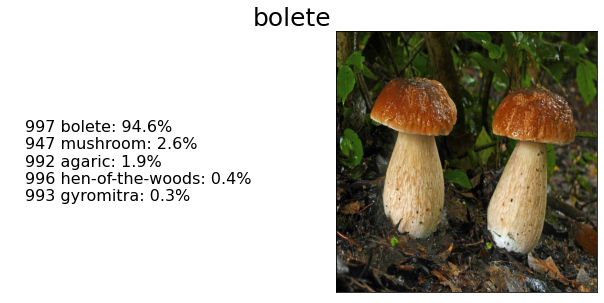

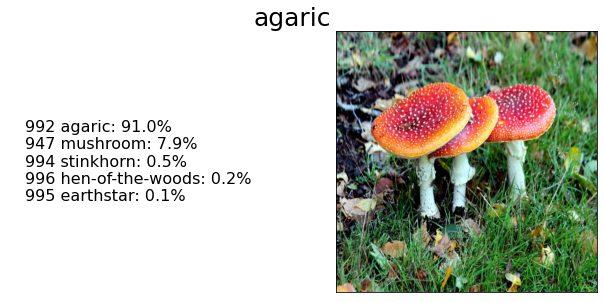

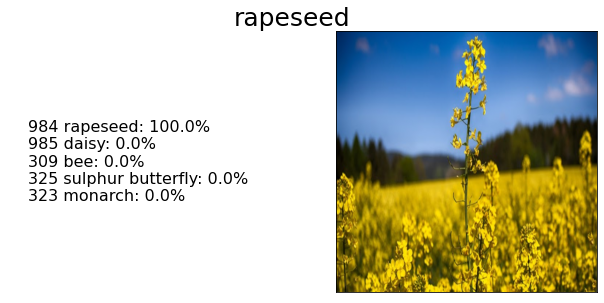

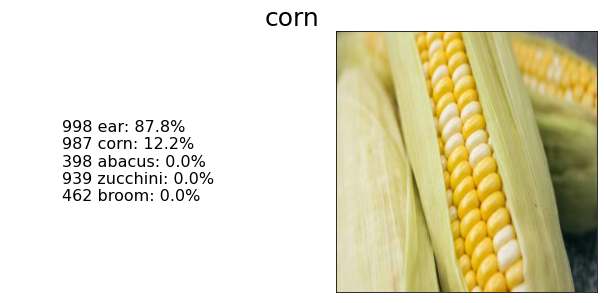

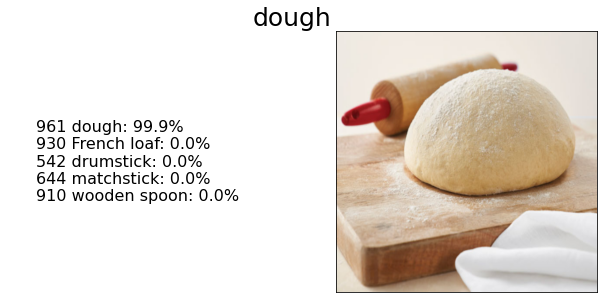

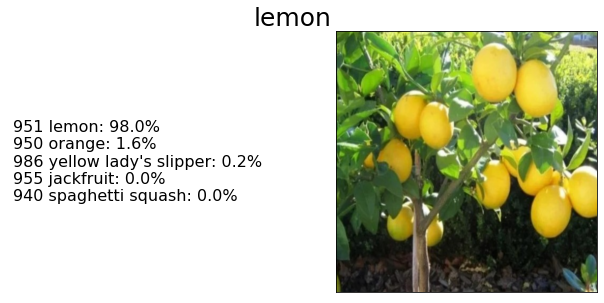

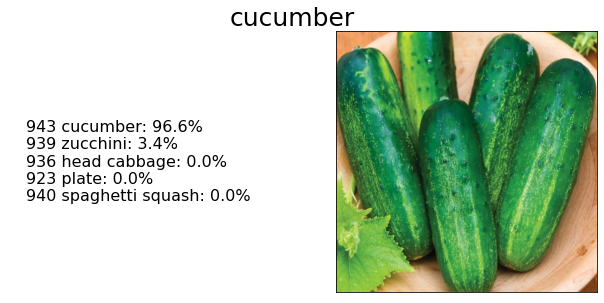

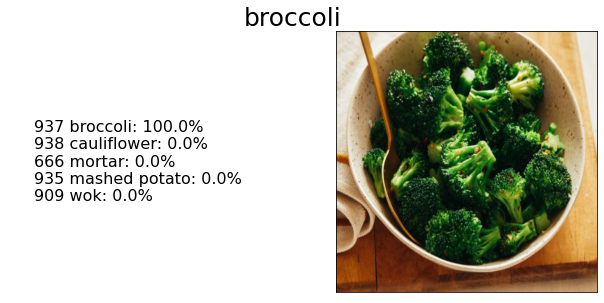

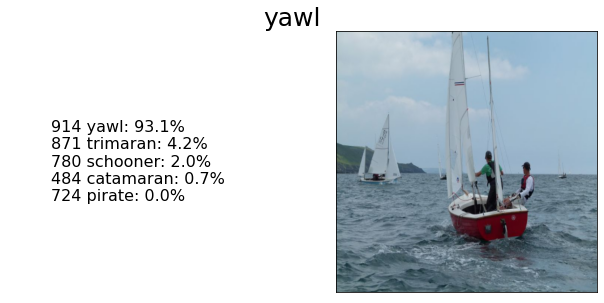

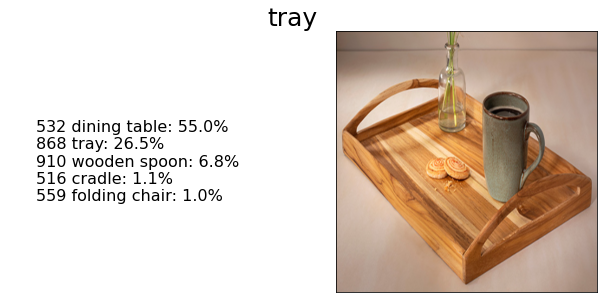

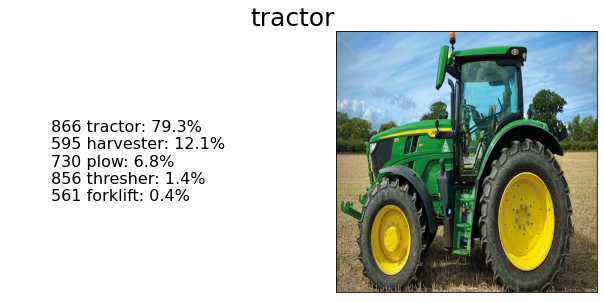

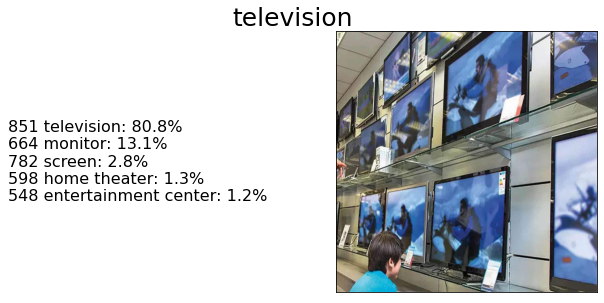

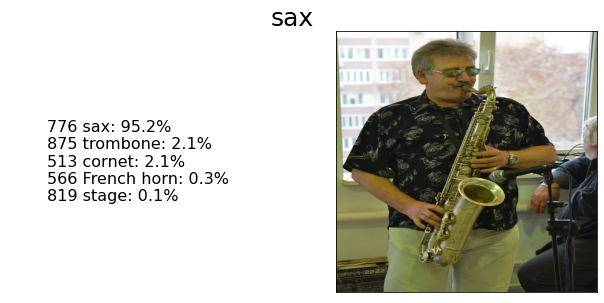

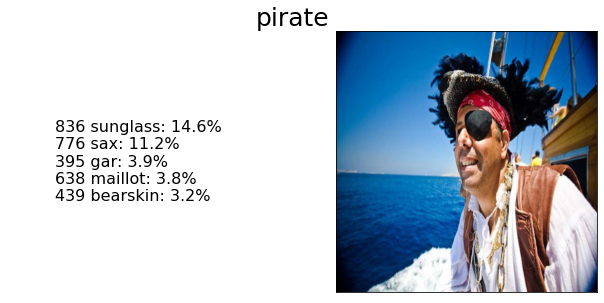

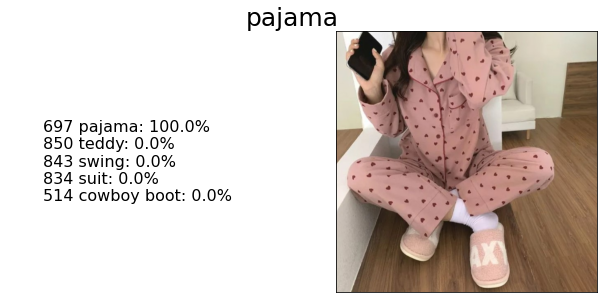

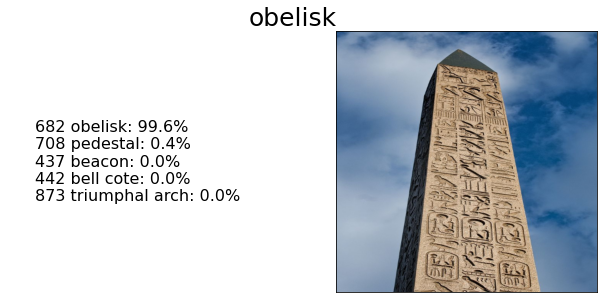

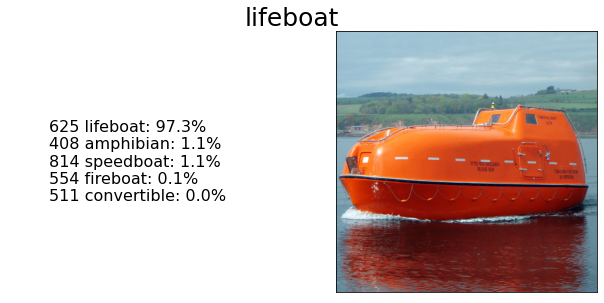

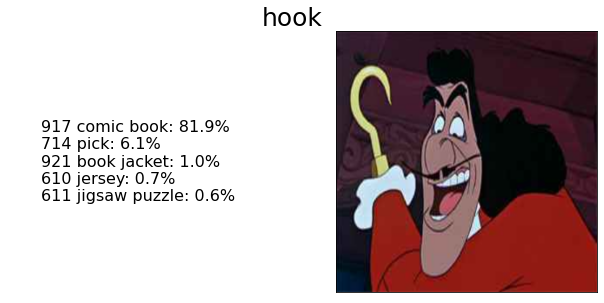

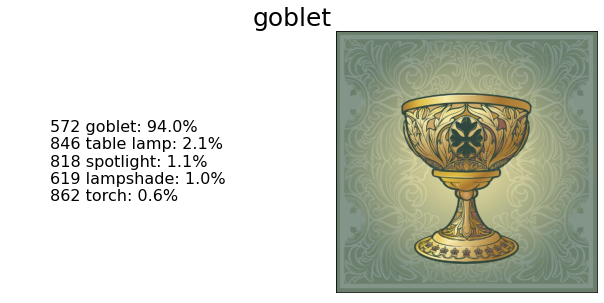

In [ ]:
from matplotlib import pyplot as plt
import numpy as np
import torchvision.transforms as T

transform = T.Resize((500,500))

if type(images[0]) == torch.Tensor:
  images = [i.cpu() for i in images]
  images = [transform(i).data.numpy().transpose((1,2,0)) for i in images]
  
for i in range(len(images)):

  fig = plt.figure(i,figsize=(10.8, 4.8))
  fig.suptitle(f"{text[i]}", fontsize=25, y=0.95)

  # Левая картинка
  ax1 = fig.add_subplot(121)
  ax1.imshow(np.full((images[i].shape[0],images[i].shape[1],3), 255, dtype= 'uint8'))

  left, width = 0, images[i].shape[1]
  bottom, height = 0, images[i].shape[0]
  right = left + width
  top = bottom + height

  ax1.text(0.5 * (left + right), 0.5 * (bottom + top), 
        description[i],
        verticalalignment  = 'center', #  вертикальное выравнивание
        multialignment = 'left', #  текст начинается слева
        horizontalalignment = 'center',    #  горизонтальное выравнивание
        color = 'black',
        fontsize = 16)
  ax1.axis('off')

  # Правая картинка
  ax2 = fig.add_subplot(122)
  ax2.imshow(images[i])
  ax2.set_xticks([]),ax2.set_yticks([])

plt.show()

In [23]:
excel = open( 'test.xls', 'a' )
excel.write('densenet161')
for element in test:
     excel.write('\t')
     excel.write(str(element))
excel.write('\n')
excel.close()